In [1]:
# for reduction of computation time:
max_events = 2

In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import math

# Plot Camera Images
####################
from ctapipe.visualization import CameraDisplay

# Read Data
###########
from konsta_cta.readdata import FileReader

from konsta_cta.image import ImagePreparer


#####################################################
# The following is not needed for the analysis as it
# is included into konta_cta.image. Here it's only
# used to clarify single steps:
#
# Calibration
#############
from ctapipe.calib.camera.r1 import HESSIOR1Calibrator
from ctapipe.calib.camera.dl0 import CameraDL0Reducer
from ctapipe.calib.camera import CameraDL1Calibrator

r1cal = HESSIOR1Calibrator()
dl0cal = CameraDL0Reducer()
dl1cal = CameraDL1Calibrator()

def calibrator(event):
    r1cal.calibrate(event)
    dl0cal.reduce(event)
    dl1cal.calibrate(event)

from ctapipe.calib import CameraCalibrator

Problem here: for r1 calibration only CameraR1CalibratorFactory possible.  
#### <span style="color:red"> How to select HESSIOR1Calibrator??  </span> 

`from ctapipe.calib import CameraCalibrator`

# List of files
Generate a list of files to use analysis or pass directly a list of files to `FileReader`. 
If `file_list` not passed directly to FileReader, the available files are searched in `directory/datatype`.

In [3]:
protons = FileReader("proton", directory="~/CTAPIPE/", max_events=max_events)
electrons = FileReader("electron", directory="~/CTAPIPE/", max_events=max_events)
gamma_cone = FileReader("gamma_cone", directory="~/CTAPIPE/", max_events=max_events)
gamma_onSource = FileReader("gamma_onSource", directory="~/CTAPIPE/", max_events=max_events)

Number of files to read: 2 for datatype proton
Number of files to read: 2 for datatype electron
Number of files to read: 2 for datatype gamma_cone
Number of files to read: 2 for datatype gamma_onSource


### Read the files

#### <span style="color:red">  To do: </span> 
Possibility to to this via generator or all together from list (maybe conflict with ctapipe??)

Generators for reading the files:

In [4]:
prot_gen = protons.files_as_generator()
elec_gen = electrons.files_as_generator()
ga_co_gen = gamma_cone.files_as_generator()
ga_on_gen = gamma_onSource.files_as_generator()

Reading of the first / next run file of the FileReader generators.

In [5]:
for particle in [prot_gen, elec_gen, ga_co_gen, ga_on_gen]:
    next(particle)

Now opening proton file 1
Now opening electron file 1
Now opening gamma_cone file 1
Now opening gamma_onSource file 1


---------
---------
Source files now accesable via `particle.source`.

#### Select only first event.

In [6]:
for event in gamma_cone.source:
    break
event

ctapipe.io.containers.DataContainer:
                          r0.*: Raw Data
                          r1.*: R1 Calibrated Data
                         dl0.*: DL0 Data Volume Reduced Data
                         dl1.*: DL1 Calibrated image
                         dl2.*: Reconstructed Shower Information
                          mc.*: Monte-Carlo data
                    mcheader.*: Monte-Carlo run header data
                        trig.*: central trigger information
                         count: number of events processed
                        inst.*: instrumental information (deprecated
                   pointing[*]: Telescope pointing positions


#### <span style="color:red">  Select telescopes for subarray </span> 
`event.inst.subarray.select_subarray()`

# Calibration

To fill data level r1, dl0 an dl1 reduction and calibration of the images are needed.

Performing the calibration of the images from r0 $\rightarrow$ dl1. Important: calibrator for r1 must fit the simulation file. In this case: `HESSIOR1Calibrator`

`CameraCalibrator` not applyable because `HESSIOR1Calibrator` not selectable.

The calibration process returns calibrated camera images in `pe` for dl1

#### Perform the calibration for event

In [7]:
calibrator(event)
image1 = event.dl1.tel[30].image
image1 = np.reshape(image1, [np.shape(image1)[1]])

Calibration using the standard method. (This one not suited for the analysis. Only applied to show the results in the plot)

In [8]:
cal = CameraCalibrator()
cal.calibrate(event)

image2 = event.dl1.tel[30].image
image2 = np.reshape(image2, [np.shape(image2)[1]])

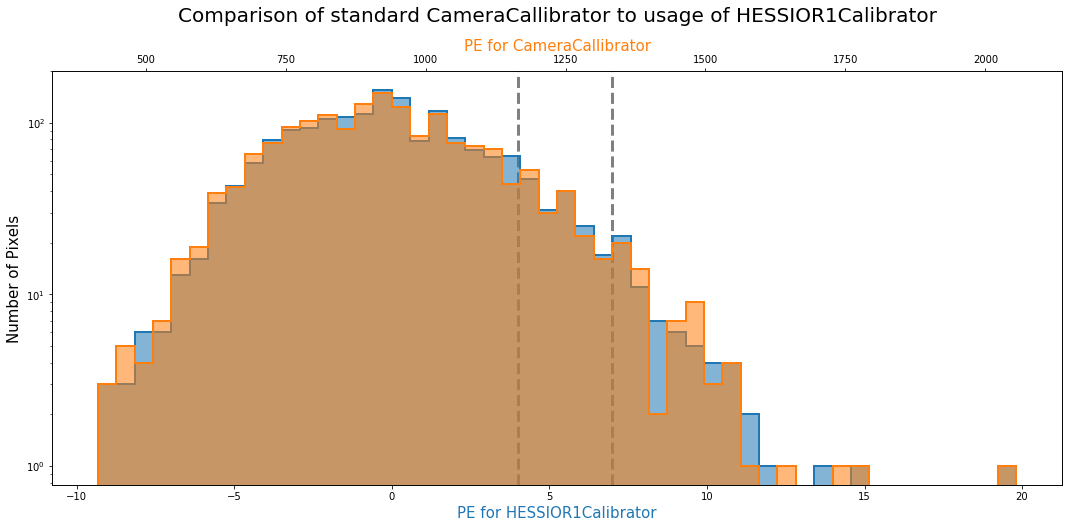

In [9]:
fig = plt.figure(figsize=[15,7])
ax1 = fig.add_subplot(111)
ax1.hist(image1, alpha=0.55, bins=50, color='C0', zorder=1)
ax1.hist(image1, alpha=1, bins=50, color='C0', histtype='step', stacked=True, linewidth=2, zorder=1)

ax2 = ax1.twiny()
ax2.hist(image2, alpha=0.55, bins=50, color='C1', zorder=1)
ax2.hist(image2, alpha=1, bins=50, color='C1', histtype='step', stacked=True, linewidth=2, zorder=1)

ax1.axvline(7, color='grey', linewidth=3, linestyle='--', zorder=0)
ax1.axvline(4, color='grey', linewidth=3, linestyle='--', zorder=0)

ax1.set_xlabel("PE for HESSIOR1Calibrator", color='C0', fontsize=15)
ax2.set_xlabel("PE for CameraCallibrator", color='C1', fontsize=15)

ax1.set_ylabel('Number of Pixels', fontsize=15)

title = "Comparison of standard CameraCallibrator to usage of HESSIOR1Calibrator"
plt.text(0.5, 1.12, title,
         horizontalalignment='center',
         fontsize=20,
         transform = ax2.transAxes)
plt.style.use(['default'])
ax1.semilogy()

plt.tight_layout()

# Image Cleaning

For the image cleaning the `tailcuts_clean` is applied. Therfore, the pixels with $pe\geq7$ are defined to be image pixels. Afterwards, the pixels with $pe\geq4$ and direct connection to at least one imgae pixls are recognized as boundary pixels. 
Furthermorem, isolated pixels are not kept and it is possible to set a minimum of neighbouring pixels to considere those as signals.

#### <span style="color:red"> What are appropriate parameters for each telescope? </span>

Besides `tailcuts_clean`, waveform cleaning already implemented in ctapipe:  
https://github.com/cta-observatory/ctapipe/blob/master/ctapipe/image/waveform_cleaning.py

Wavelet cleaning:  
https://github.com/jdhp-sap/ctapipe-wavelet-filter

##### Peforming tailcut cleaning and image parametrization for each event.

All telescopes that recorded data for each event and particle type and applies the image cleaning. The resulting images that are not empty are then stored in the `dict` named `cleaned_images`. For each of the cleaned images, the hillas moments are calculated and stored in `hillas_moments`.

The keys of the two `dicts` are named the following: `['datatype', 'event_id', 'tel_id']`

#### <span style="color:red">  Do I need runnumber for later? </span> 

In [10]:
images = ImagePreparer([protons, electrons, gamma_cone, gamma_onSource])
images.analysis()

Processed 10 images for datatype proton. Imagesthat didn't survive cleaning: 1
Processed 26 images for datatype electron. Imagesthat didn't survive cleaning: 10
Processed 9 images for datatype gamma_cone. Imagesthat didn't survive cleaning: 0
Processed 26 images for datatype gamma_onSource. Imagesthat didn't survive cleaning: 0


#### Plot all cleaned camera images separated in the different particle types

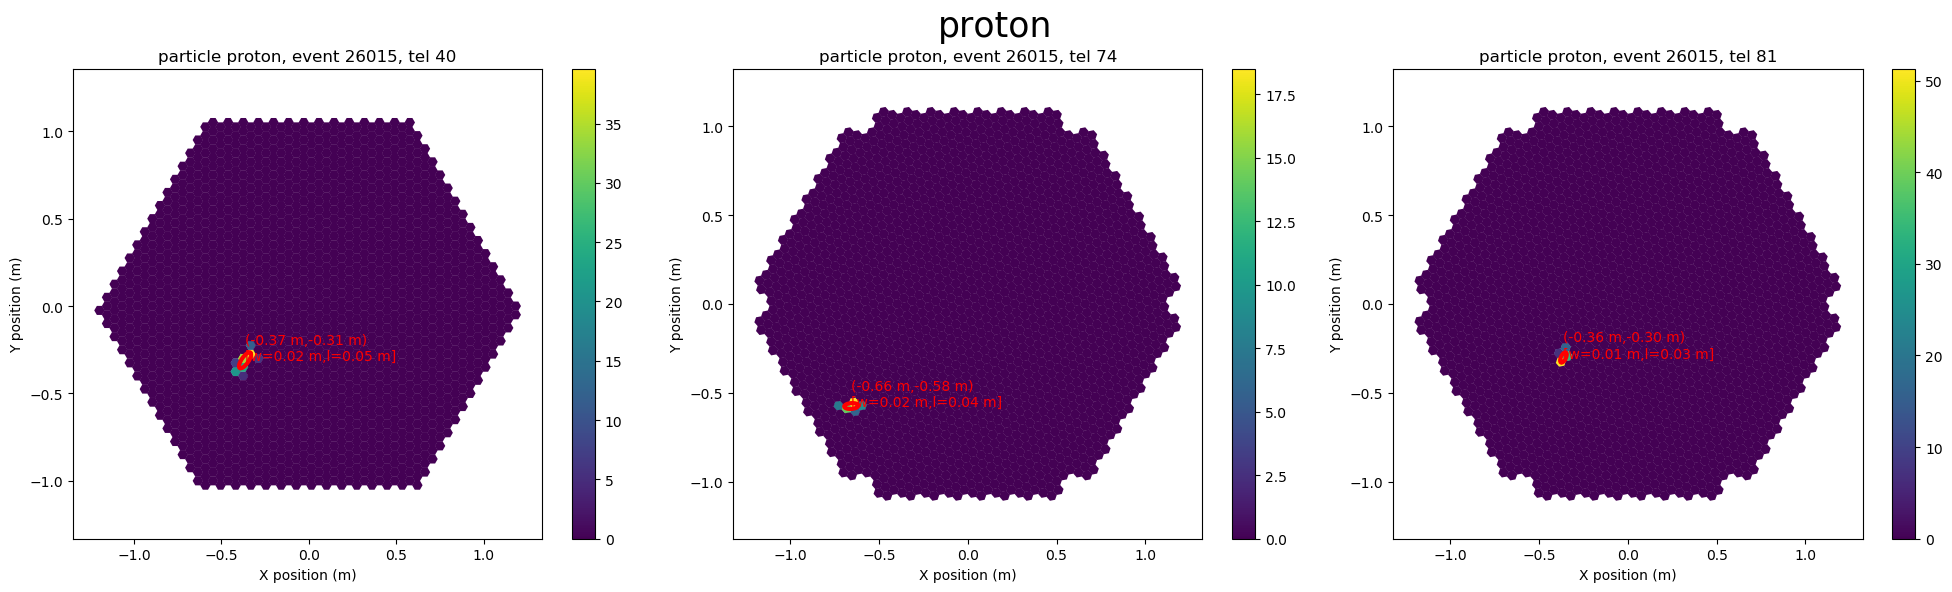

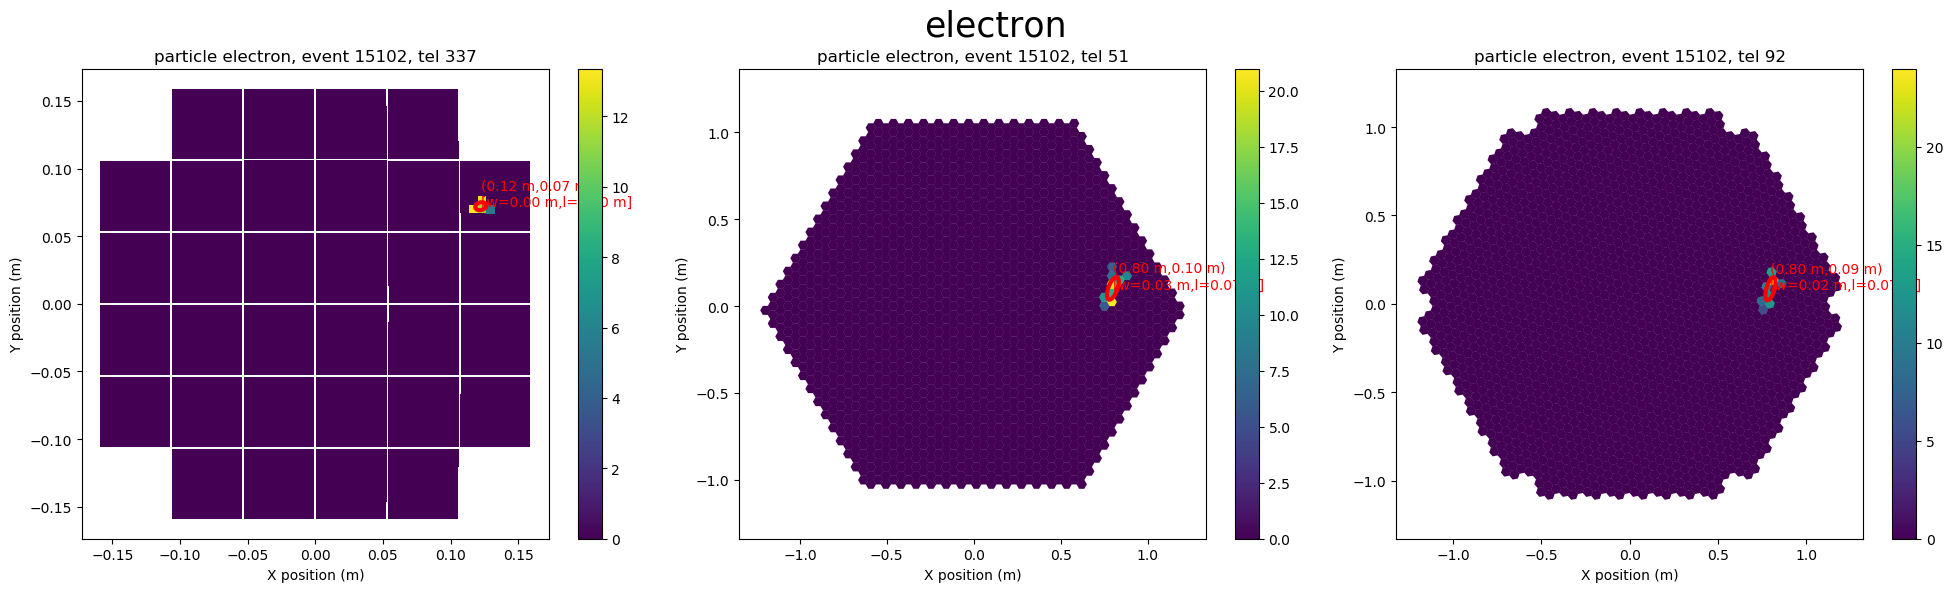

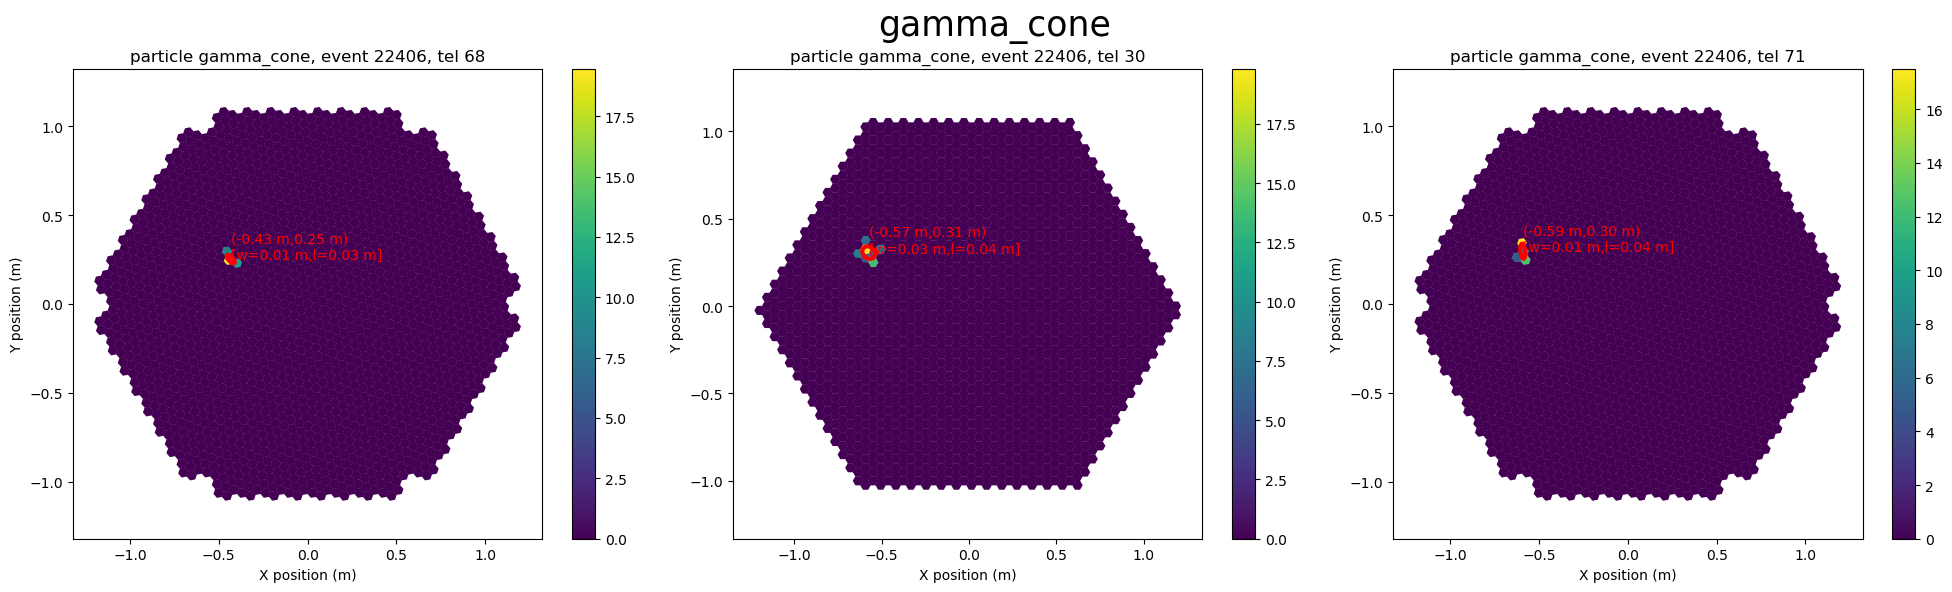

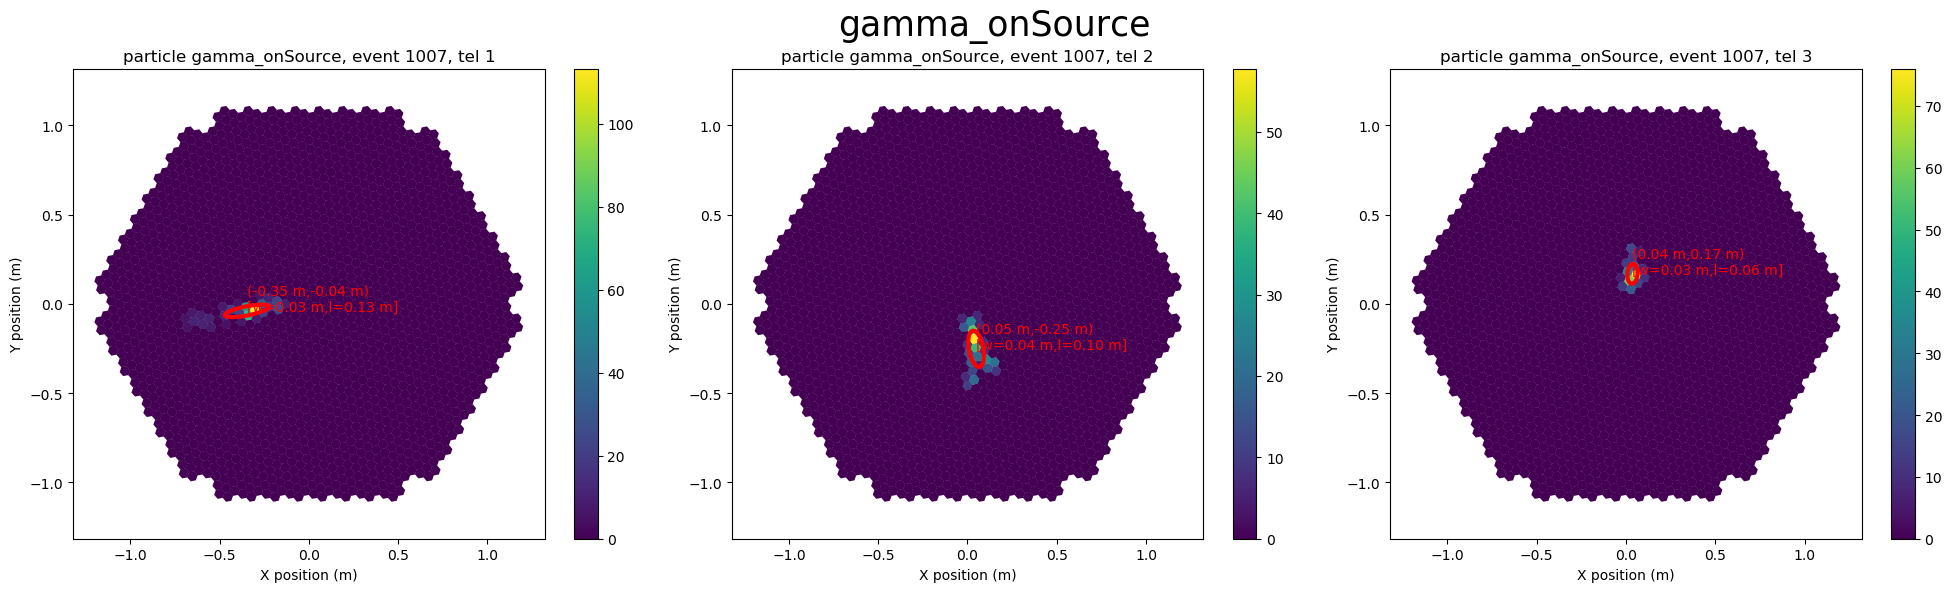

In [11]:
# get searchable array of the keys
keys = images.keys
geoms = images.geoms

# maximum number of rows for each particle type:
max_rows = 1

# loop through all particle types
for particle in [protons, electrons, gamma_cone, gamma_onSource]:
    
    if not max_rows:
        # calculate number of rows needed for plot
        rows = math.ceil(images.n_images_after_cleaning[particle.datatype]/3)
        # keys of the dictionary belonging to this particle type
        keys_for_particle = enumerate(np.arange(0,len(keys))[keys[:,0]==particle.datatype])
    elif math.ceil(images.n_clean_images[particle.datatype]/3) <= max_rows:
        # in case of number of images is smaler than 3*max_rows,
        # use the actual needed number of rows for the plot
        rows = math.ceil(images.n_clean_images[particle.datatype]/3)
        keys_for_particle = enumerate(np.arange(0,len(keys))[keys[:,0]==particle.datatype])
    else:    
        rows = max_rows
        # if max_rows is relevant plot only first 3 * max_row images
        keys_for_particle = enumerate(np.arange(0,len(keys))[keys[:,0]==particle.datatype][0:(rows*3)])
    
    # Generate one plot for each particle type
    fig = plt.figure(figsize=[20,1+5*rows])
    
    for k, i in keys_for_particle:  
        image = images.clean_images[keys[i,0], int(keys[i,1]), int(keys[i,2])]
        hillas_moments = images.hillas_moments[keys[i,0], int(keys[i,1]), int(keys[i,2])]
        geom = geoms[int(keys[i,2])]
        # setub the subplots
        plt.subplot(rows,3,k+1)
        title="particle {}, event {}, tel {}".format(keys[i,0], keys[i,1], keys[i,2])
        # Plot the images
        disp = CameraDisplay(geom, image=image, title=title)
        disp.cmap = plt.cm.viridis
        disp.add_colorbar()
        disp.overlay_moments(hillas_moments, color='red', linewidth=3)
    
    
    plt.suptitle(particle.datatype, fontsize=25)
    plt.tight_layout()
    # Adjust space for suptitle
    fig.subplots_adjust(top = 1 - (0.12 / rows**(1.1/2))  )
    plt.show()
    plt.close()

# <span style="color:red">  $\gamma$/h - separation </span> 

# <span style="color:red">  Energy reconstruction </span> 

# <span style="color:red">  Direction reconstruction </span> 

# <span style="color:red">  Effective areas </span> 